
- do some basic EDA
- take database and decide on relevant features (using shap scores?)
- Train XGB to predict the error of the models
- (After we can train something to predict error + bias)

In [1]:
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold


from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
)
import shap

/home/ntion/miniconda3/envs/topfarm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some Logic to take the different height values for ws and wd etc. and create some variable which represents the shape

In doing this, we are taking the combined dataset with all the height values and extracting only what we need and what is feasible to fit an error predictor on

I am not familiar with such variables.... all I have done here is taken the hub height values

In [2]:
# Load dataset
xr_data=xr.load_dataset("results_stacked_hh.nc")
df=xr_data.to_dataframe().reset_index()
df['log_z0']=np.log(df['z0'].values)
xr_data

<xarray.Dataset> Size: 101kB
Dimensions:                      (sample: 50, case_index: 182)
Coordinates:
  * sample                       (sample) int64 400B 0 1 2 3 4 ... 46 47 48 49
    k_b                          (sample) float64 400B 0.1309 0.2189 ... 0.04771
    ss_alpha                     (sample) float64 400B 0.7597 1.089 ... 1.059
    wind_farm                    (case_index) <U22 16kB 'hr_blh_800m' ... 'vw...
    flow_case                    (case_index) float64 1kB 0.0 1.0 ... 14.0 15.0
Dimensions without coordinates: case_index
Data variables:
    power_err_norm               (sample, case_index) float64 73kB 0.1648 ......
    wind_speed                   (case_index) float64 1kB 9.947 9.971 ... 12.97
    wind_direction               (case_index) float64 1kB 14.98 9.983 ... 270.0
    turbulence_intensity         (case_index) float64 1kB 0.06973 ... 0.04089
    potential_temperature        (case_index) float64 1kB 20.45 20.45 ... 19.48
    z0                           (case_index) float32 728B 0.00209 ... 0.0002
    LMO                          (case_index) float32 728B 1e+05 1e+05 ... 1e+05
    ABL_height                   (case_index) float32 728B 800.0 800.0 ... 350.0
    capping_inversion_strength   (case_index) float32 728B 2.0 2.0 ... 2.0 2.0
    capping_inversion_thickness  (case_index) float32 728B 300.0 300.0 ... 300.0

In [3]:
df

,sample,case_index,power_err_norm,wind_speed,wind_direction,turbulence_intensity,potential_temperature,z0,LMO,ABL_height,capping_inversion_strength,capping_inversion_thickness,k_b,ss_alpha,wind_farm,flow_case,log_z0
0,0,0,0.164820,9.946975,14.983102,0.069730,20.446933,0.002090,100000.0,800.0,2.0,300.0,0.130936,0.759683,hr_blh_800m,0.0,-6.170591
1,0,1,0.121375,9.971009,9.983315,0.089637,20.454332,0.020800,100000.0,800.0,2.0,300.0,0.130936,0.759683,hr_blh_800m,1.0,-3.872802
2,0,2,0.174087,9.952359,4.983150,0.078817,20.449933,0.006864,100000.0,800.0,2.0,300.0,0.130936,0.759683,hr_blh_800m,2.0,-4.981465
3,0,3,0.280977,9.955688,-0.016862,0.075104,20.448632,0.004365,100000.0,800.0,2.0,300.0,0.130936,0.759683,hr_blh_800m,3.0,-5.434137
4,0,4,0.303853,9.950229,-5.016874,0.075284,20.448632,0.004467,100000.0,800.0,2.0,300.0,0.130936,0.759683,hr_blh_800m,4.0,-5.411038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9095,49,177,0.230355,12.965957,269.993759,0.050025,19.475408,0.000200,100000.0,1250.0,2.0,300.0,0.047708,1.058572,vwf_22mw_5x_5y,11.0,-8.517193
9096,49,178,0.258059,12.981516,269.993522,0.050533,19.475408,0.000200,100000.0,2000.0,2.0,300.0,0.047708,1.058572,vwf_22mw_5x_5y,12.0,-8.517193
9097,49,179,0.217067,12.983409,269.950750,0.025921,19.624398,0.000200,100000.0,150.0,2.0,300.0,0.047708,1.058572,vwf_22mw_5x_5y,13.0,-8.517193
9098,49,180,0.226424,12.972423,269.985570,0.035640,19.496860,0.000200,100000.0,250.0,2.0,300.0,0.047708,1.058572,vwf_22mw_5x_5y,14.0,-8.517193


Shap Scores / Feature Engineering
- Split into training and test data.... then scale
- Then Using XGboost... tuning parameters
- Look at shap scores
- Look at feature importances
- Decide on features to keep

In [4]:

features=df.drop(['sample','case_index','wind_farm','flow_case','power_err_norm'],axis=1)
target=df[['power_err_norm']]
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=0, shuffle=True)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Looking at RMSE as a function of n_estimators in Xgboost

RMSE: 0.100346075556135
RMSE: 0.09289282094350593
RMSE: 0.07970556669097878
RMSE: 0.0591454894176761
RMSE: 0.034976531325785
RMSE: 0.022553090305630057
RMSE: 0.024283368051033753
RMSE: 0.025089031622671006


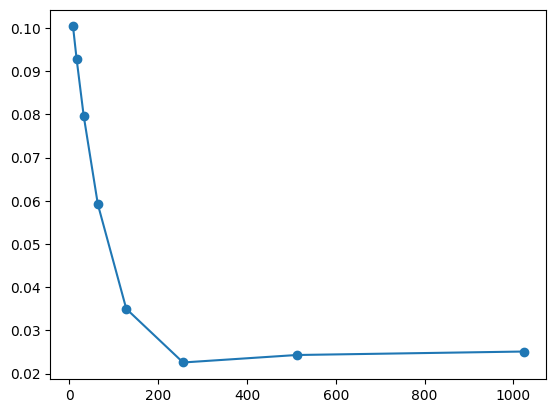

In [5]:
n_estimators = [8, 16, 32, 64, 128, 256, 512, 1024]
errs = []

for n_est in n_estimators:

    # XGBoost regression model
    xg_reg = xgb.XGBRegressor(n_estimators=n_est, max_depth=15, eta=0.01)

    # Training the model
    xg_reg.fit(X_train_scaled, y_train)

    # Predicting on test set
    y_pred = xg_reg.predict(X_test_scaled)

    # Calculating RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE: {rmse}")
    errs.append(rmse)
    
plt.plot(n_estimators, errs, marker='o')

In [6]:
y_pred.shape


(2275,)

Text(0.5, 1.0, 'Mean absolute Error 0.007170947868355294')

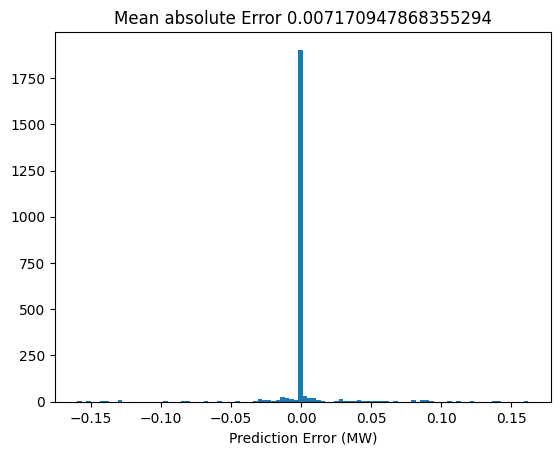

In [7]:
# XGBoost regression model
xg_reg = xgb.XGBRegressor(n_estimators=1024, max_depth=15, eta=0.01)

# Training the model
xg_reg.fit(X_train_scaled, y_train)

# Predicting on test set
y_pred = xg_reg.predict(X_test_scaled)

plt.hist(y_test.values.flatten()- y_pred, 100)
plt.xlabel('Prediction Error (MW)')
plt.title(f'Mean absolute Error {np.mean(np.abs(y_test.values.flatten() - y_pred))}')


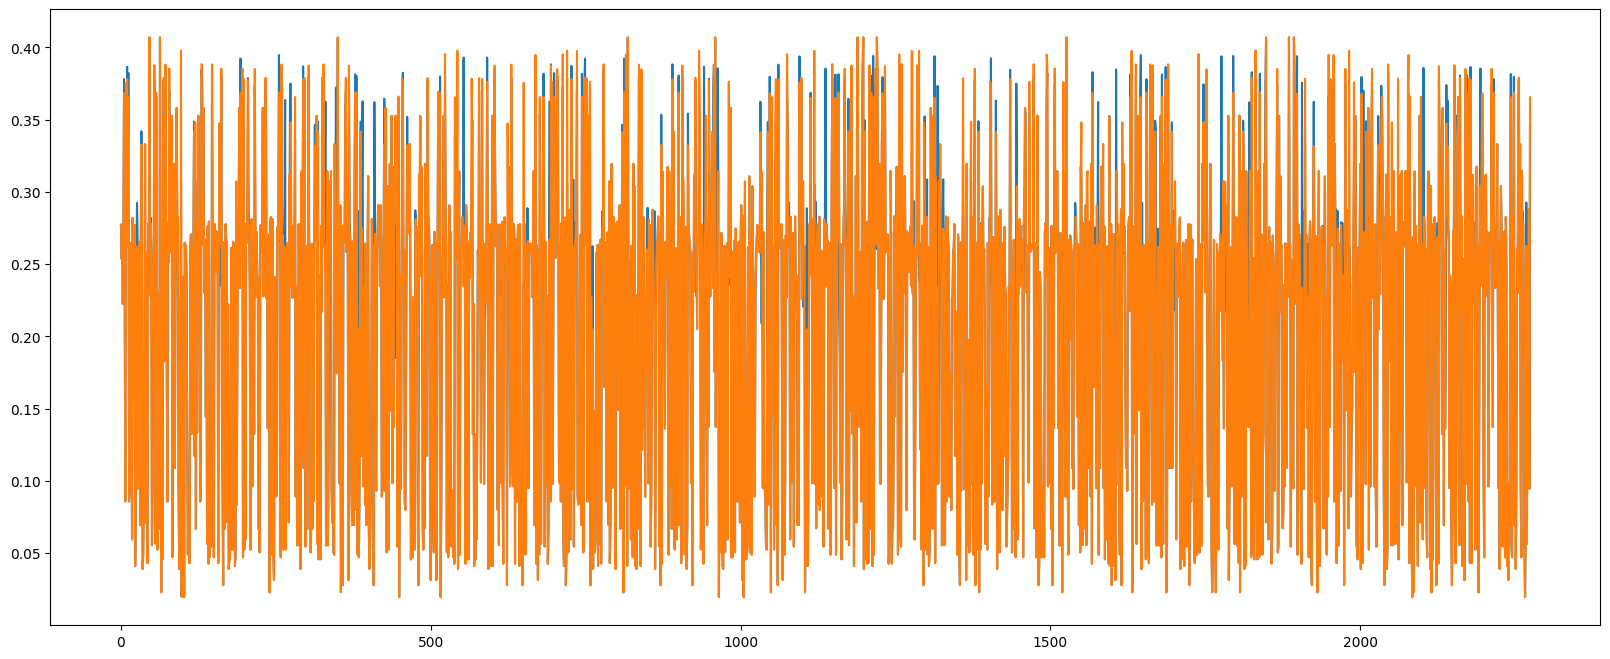

In [8]:
# Plotting predictions vs test values (difficult to interpret)
plt.figure(figsize=(20,8))
plt.plot(y_pred)
plt.plot(y_test.values)

Shap scores



https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html

Fold 1/10
Fold 2/10
Fold 3/10
Fold 4/10
Fold 5/10
Fold 6/10
Fold 7/10
Fold 8/10
Fold 9/10
Fold 10/10


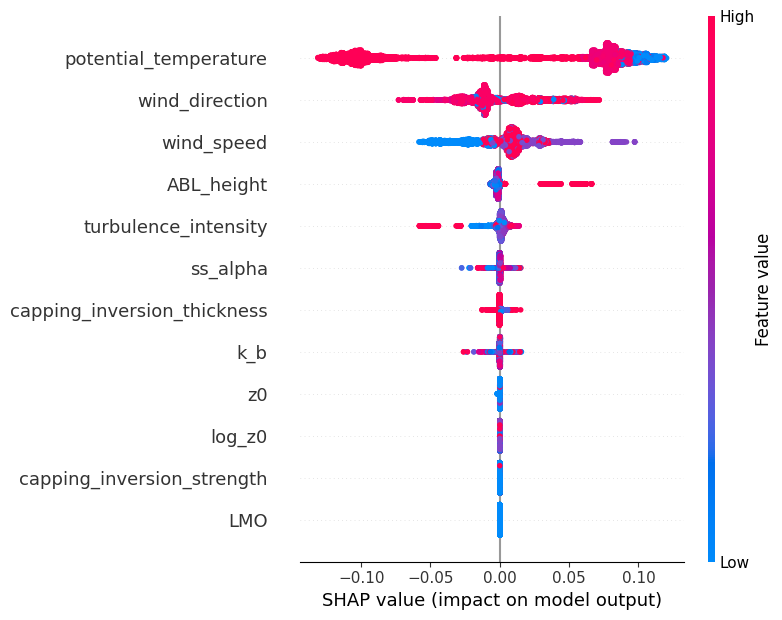

In [9]:
def plot_shap_values_with_kfold(scaled_features, targets, feature_names=None, n_splits=10, random_state=15):
    """

    uses k-fold cross validation to train xgboost and aggregates the shap values
    for each fold. Then visualizes shap values for model interpretability

    """
   
   # if scaled_features is not a dataframe, (a numpy array) you need to prove the feature names additionally
    if isinstance(scaled_features, np.ndarray):
        if feature_names is None:
            raise ValueError("You must provide feature_names when using ndarray input.")
        X = pd.DataFrame(scaled_features, columns=feature_names)
    else:
        X = scaled_features.copy()
        feature_names = X.columns.tolist()

    y = targets

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)


    all_shap_values = []
    all_X_test = []
    all_y_test = []
    
    # KFold cross-validation loop
    for fold_idx, (train_idx, test_idx) in enumerate(kf.split(X, y)):
        print(f"Fold {fold_idx + 1}/{n_splits}")
        
        X_train_raw, X_test_raw = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Fit scaler only on training data
        scaler = StandardScaler()
        X_train = pd.DataFrame(scaler.fit_transform(X_train_raw), columns=feature_names, index=X_train_raw.index)
        X_test = pd.DataFrame(scaler.transform(X_test_raw), columns=feature_names, index=X_test_raw.index)


        model=xgb.XGBRegressor(n_estimators=1024, random_state=random_state)
        model.fit(X_train, y_train)

        explainer = shap.Explainer(model, X_train)

        shap_values = explainer(X_test,check_additivity=False)

        all_shap_values.append(shap_values.values)
        all_X_test.append(X_test)
        all_y_test.append(y_test)
    
    combined_shap_values = np.concatenate(all_shap_values, axis=0)
    combined_X_test = pd.concat(all_X_test, axis=0)
        

    plt.figure()
    shap.summary_plot(combined_shap_values, combined_X_test, feature_names=feature_names, show=True)
        # plt.title(f"{model_name}\n{target[target_index]}")
        # plt.savefig(f'plots/shap/{model_name}_{target_vars[target_index]}.png')

plot_shap_values_with_kfold(features, target)

Predicting Error (Using XGboost)
- Adjust the input features
- Showing predicted vs actual 
- Cross validation results of prediction


In [14]:
selected_features=features[['turbulence_intensity','wind_direction','wind_speed', 'ABL_height','potential_temperature']]

In [15]:
selected_features

,turbulence_intensity,wind_direction,wind_speed,ABL_height,potential_temperature
0,0.069730,14.983102,9.946975,800.0,20.446933
1,0.089637,9.983315,9.971009,800.0,20.454332
2,0.078817,4.983150,9.952359,800.0,20.449933
3,0.075104,-0.016862,9.955688,800.0,20.448632
4,0.075284,-5.016874,9.950229,800.0,20.448632
...,...,...,...,...,...
9095,0.050025,269.993759,12.965957,1250.0,19.475408
9096,0.050533,269.993522,12.981516,2000.0,19.475408
9097,0.025921,269.950750,12.983409,150.0,19.624398
9098,0.035640,269.985570,12.972423,250.0,19.496860


In [16]:
def cross_validate_and_log(features, targets):
    n_splits=10
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=5)
    X=features
    y=target
    
    model=xgb.XGBRegressor(n_estimators=1024, random_state=15)

    results = []

    
    for fold_idx, (train_idx, test_idx) in enumerate(kf.split(X, y)):
        print(f"Fold {fold_idx + 1}/{n_splits}")
        
        X_train_raw, X_test_raw = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Fit scaler only on training data
        scaler = StandardScaler()
        X_train = pd.DataFrame(scaler.fit_transform(X_train_raw), columns=None, index=X_train_raw.index)
        X_test = pd.DataFrame(scaler.transform(X_test_raw), columns=None, index=X_test_raw.index)
        

        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        r2 = r2_score(y_test, predictions)
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, predictions)
        bias = np.mean(predictions - y_test.values.flatten())
        
        results.append({
            "R^2": r2,
            "MSE": mse,
            "RMSE": rmse,
            "MAE": mae,
            "Bias": bias
        })

    results_df = pd.DataFrame(results)
    return results_df

results_df=cross_validate_and_log(selected_features,target)

Fold 1/10
Fold 2/10
Fold 3/10
Fold 4/10
Fold 5/10
Fold 6/10
Fold 7/10
Fold 8/10
Fold 9/10
Fold 10/10


In [17]:
results_df

,R^2,MSE,RMSE,MAE,Bias
0,0.981202,0.000229,0.015131,0.004458,-0.000514
1,0.974722,0.000305,0.017476,0.005177,0.000160
2,0.977093,0.000276,0.016616,0.005048,-0.000011
3,0.980538,0.000228,0.015085,0.004324,-0.000545
4,0.982007,0.000222,0.014886,0.004354,-0.000484
5,0.980384,0.000236,0.015370,0.004369,0.000043
6,0.978159,0.000254,0.015935,0.004556,0.000732
7,0.984673,0.000180,0.013413,0.003720,0.000466
8,0.972631,0.000312,0.017666,0.005555,-0.000080
9,0.983296,0.000189,0.013730,0.003938,0.000261
